In [14]:
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy.stats import pearsonr
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import (
    PrecisionRecallDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance

In [15]:
wine_df = pd.read_csv(
        "https://github.com/tucros/school_datasets/blob/main/winequality-white.csv?raw=true",
        sep=";",
    )

print("\nPreprocessing.....")
print(f"{wine_df.shape} Rows and Columns")

print("\nFrame info")
print(wine_df.info())

print("\nFrame description")
print(wine_df.describe())

null_rows = wine_df[wine_df.isnull().any(axis=1)]
print(f"\nRows with null values: {len(null_rows)}")
if len(null_rows) > 0:
    wine_df.dropna(inplace=True)

duplicate_rows = wine_df[wine_df.duplicated()]
print(f"Duplicate rows: {len(duplicate_rows)}")
if len(duplicate_rows) > 0:
    wine_df.drop_duplicates(inplace=True)

wine_df["quality"] = wine_df["quality"].astype("category")


Preprocessing.....
(4898, 12) Rows and Columns

Frame info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
None

Frame description
       fixed acidity  volatile acidity  ci

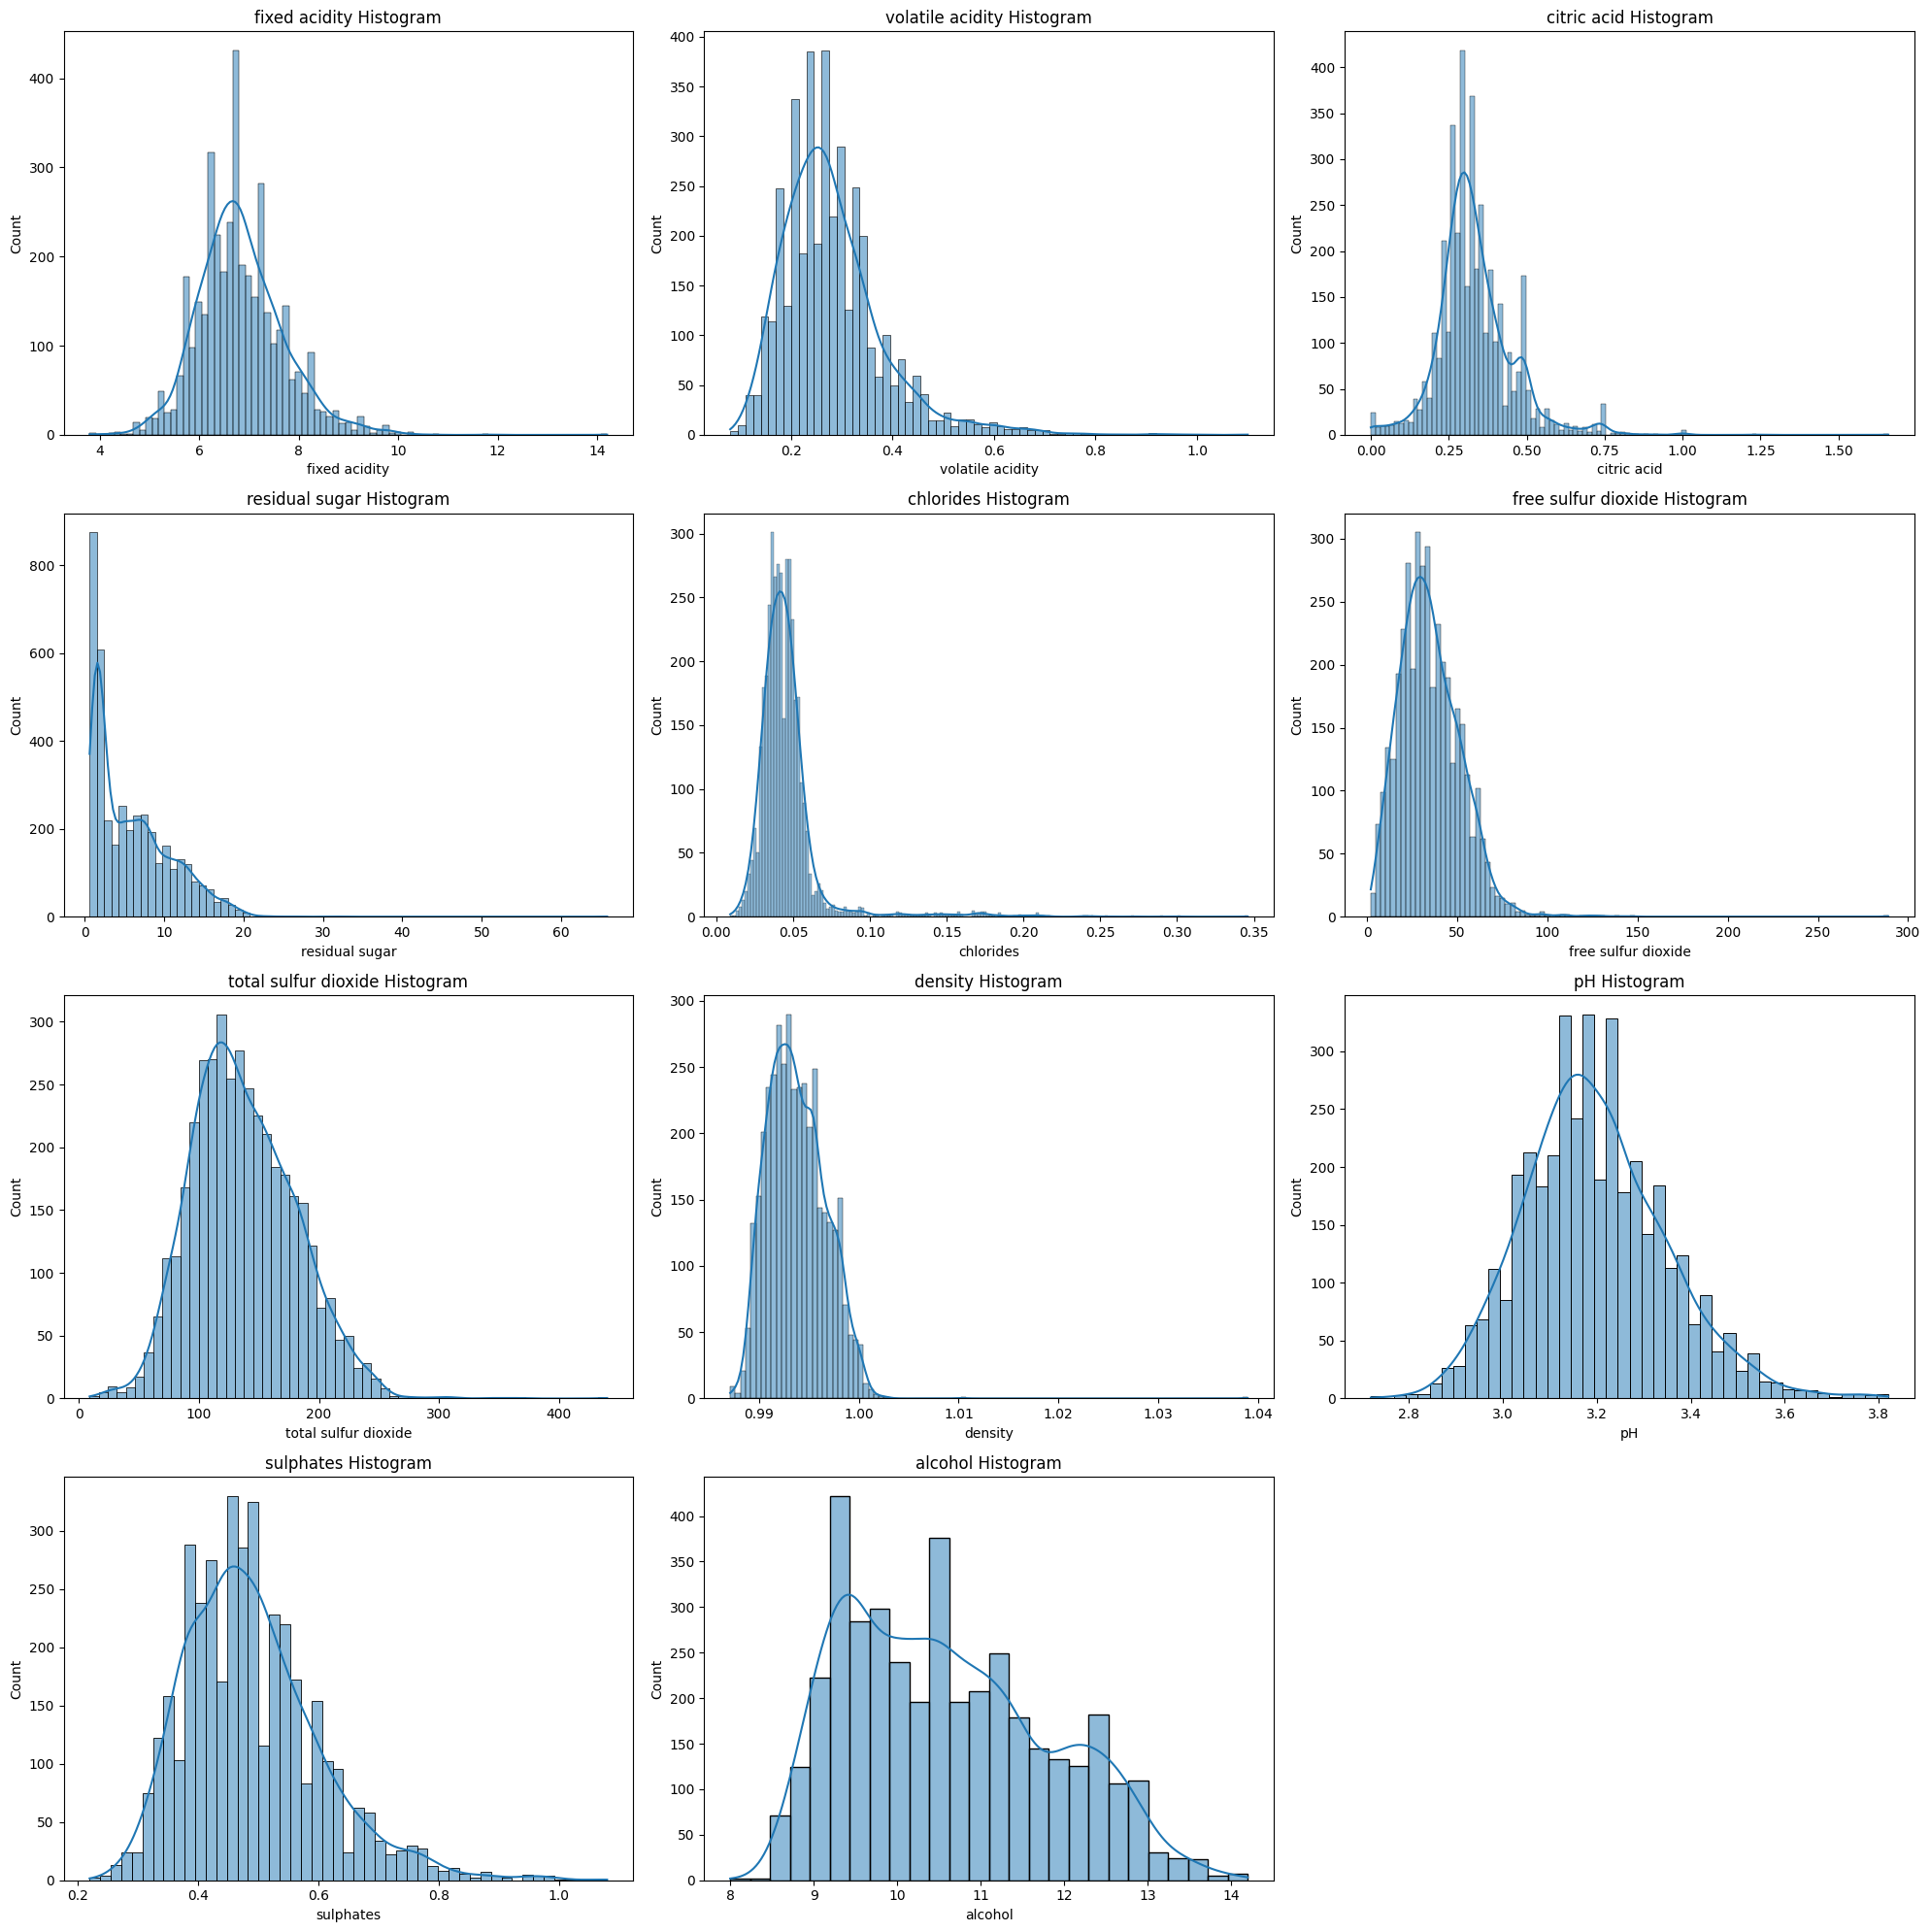

In [16]:
plt.figure(figsize=(20, 20))
cnt = 0
for column in wine_df.columns:
    if column not in {"quality"}:
        plt.subplot(4, 3, cnt + 1)
        sns.histplot(wine_df[column], kde=True)
        plt.title(f"{column} Histogram")
        cnt += 1
plt.tight_layout()
plt.show()

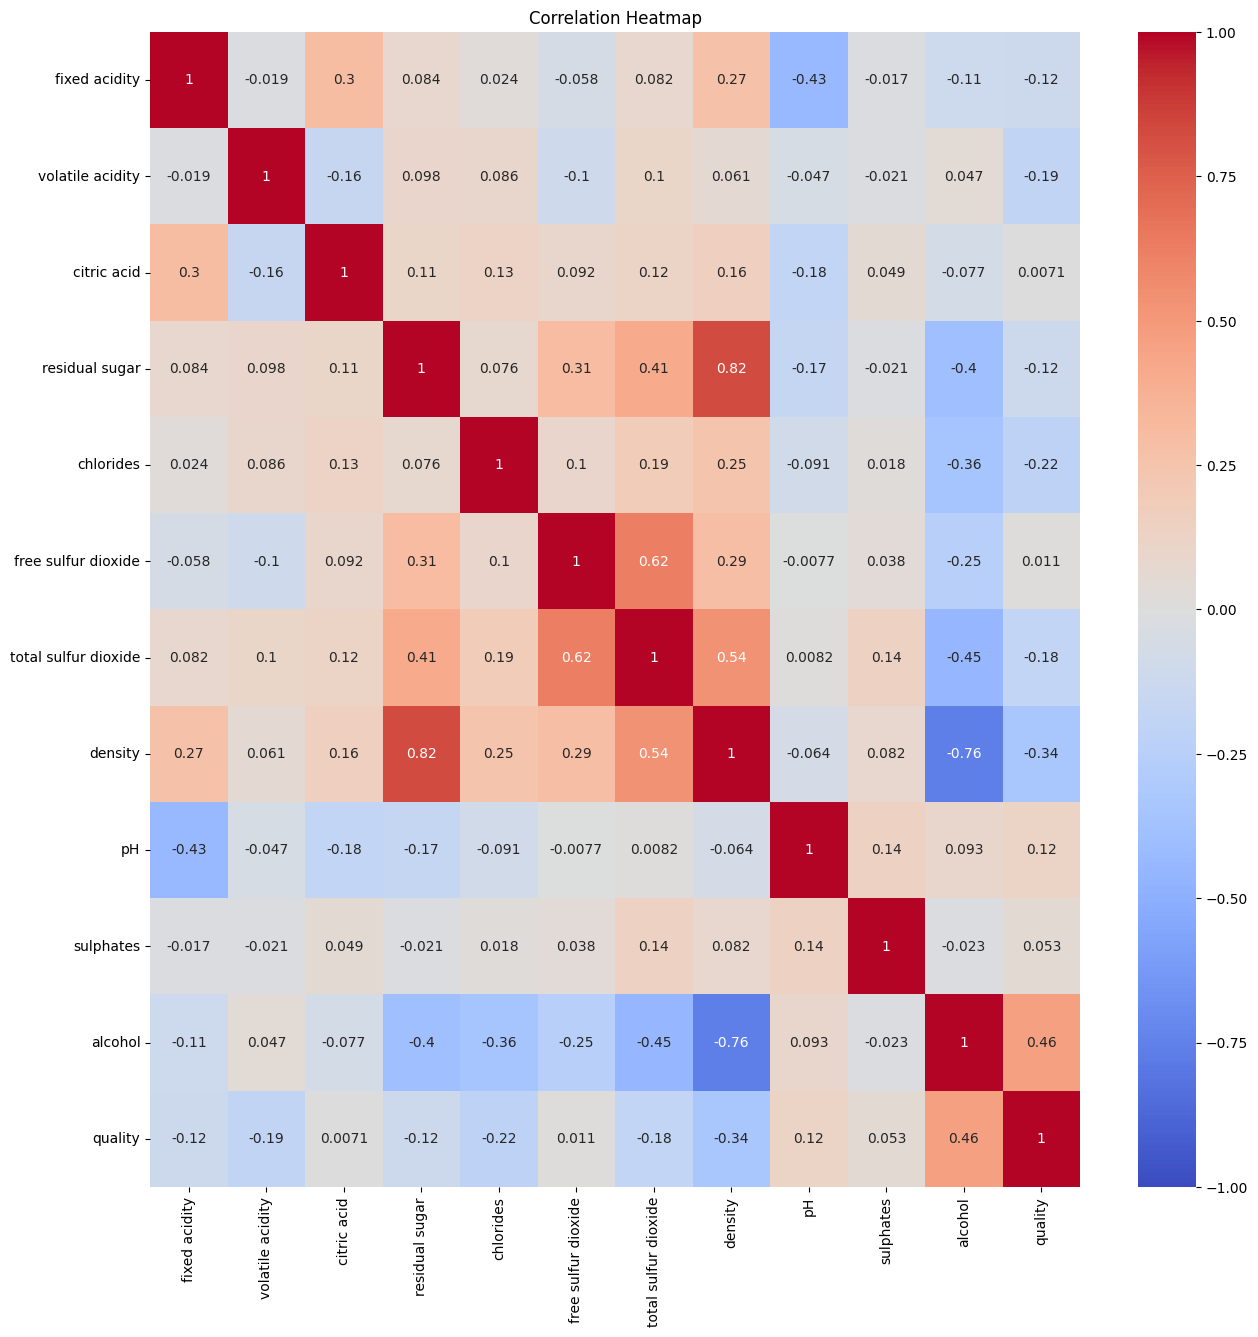

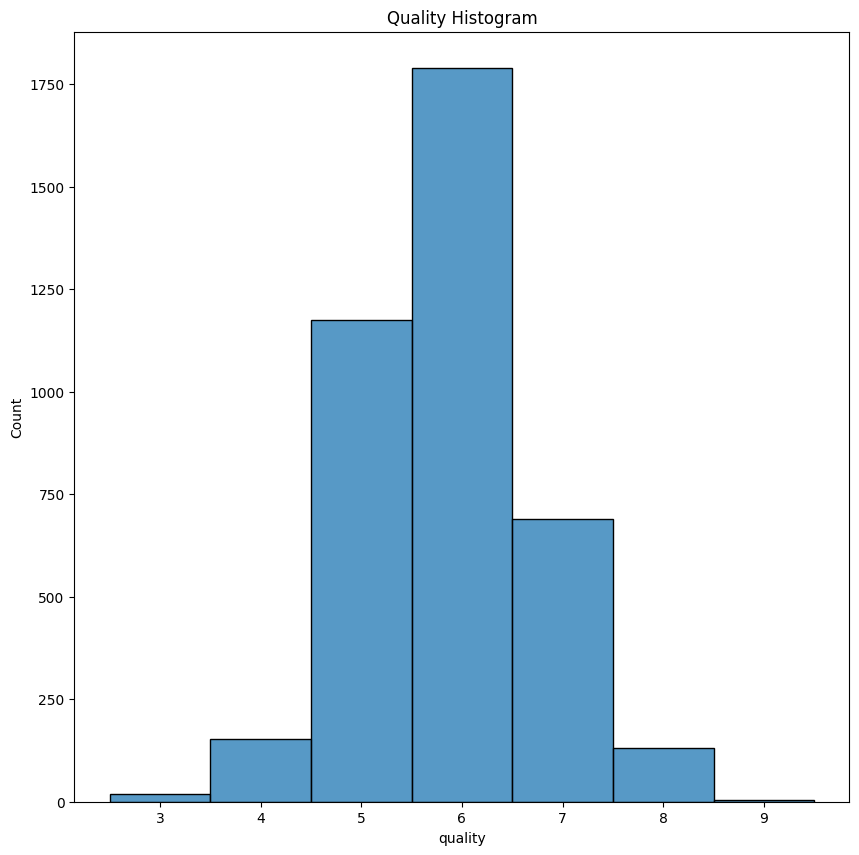

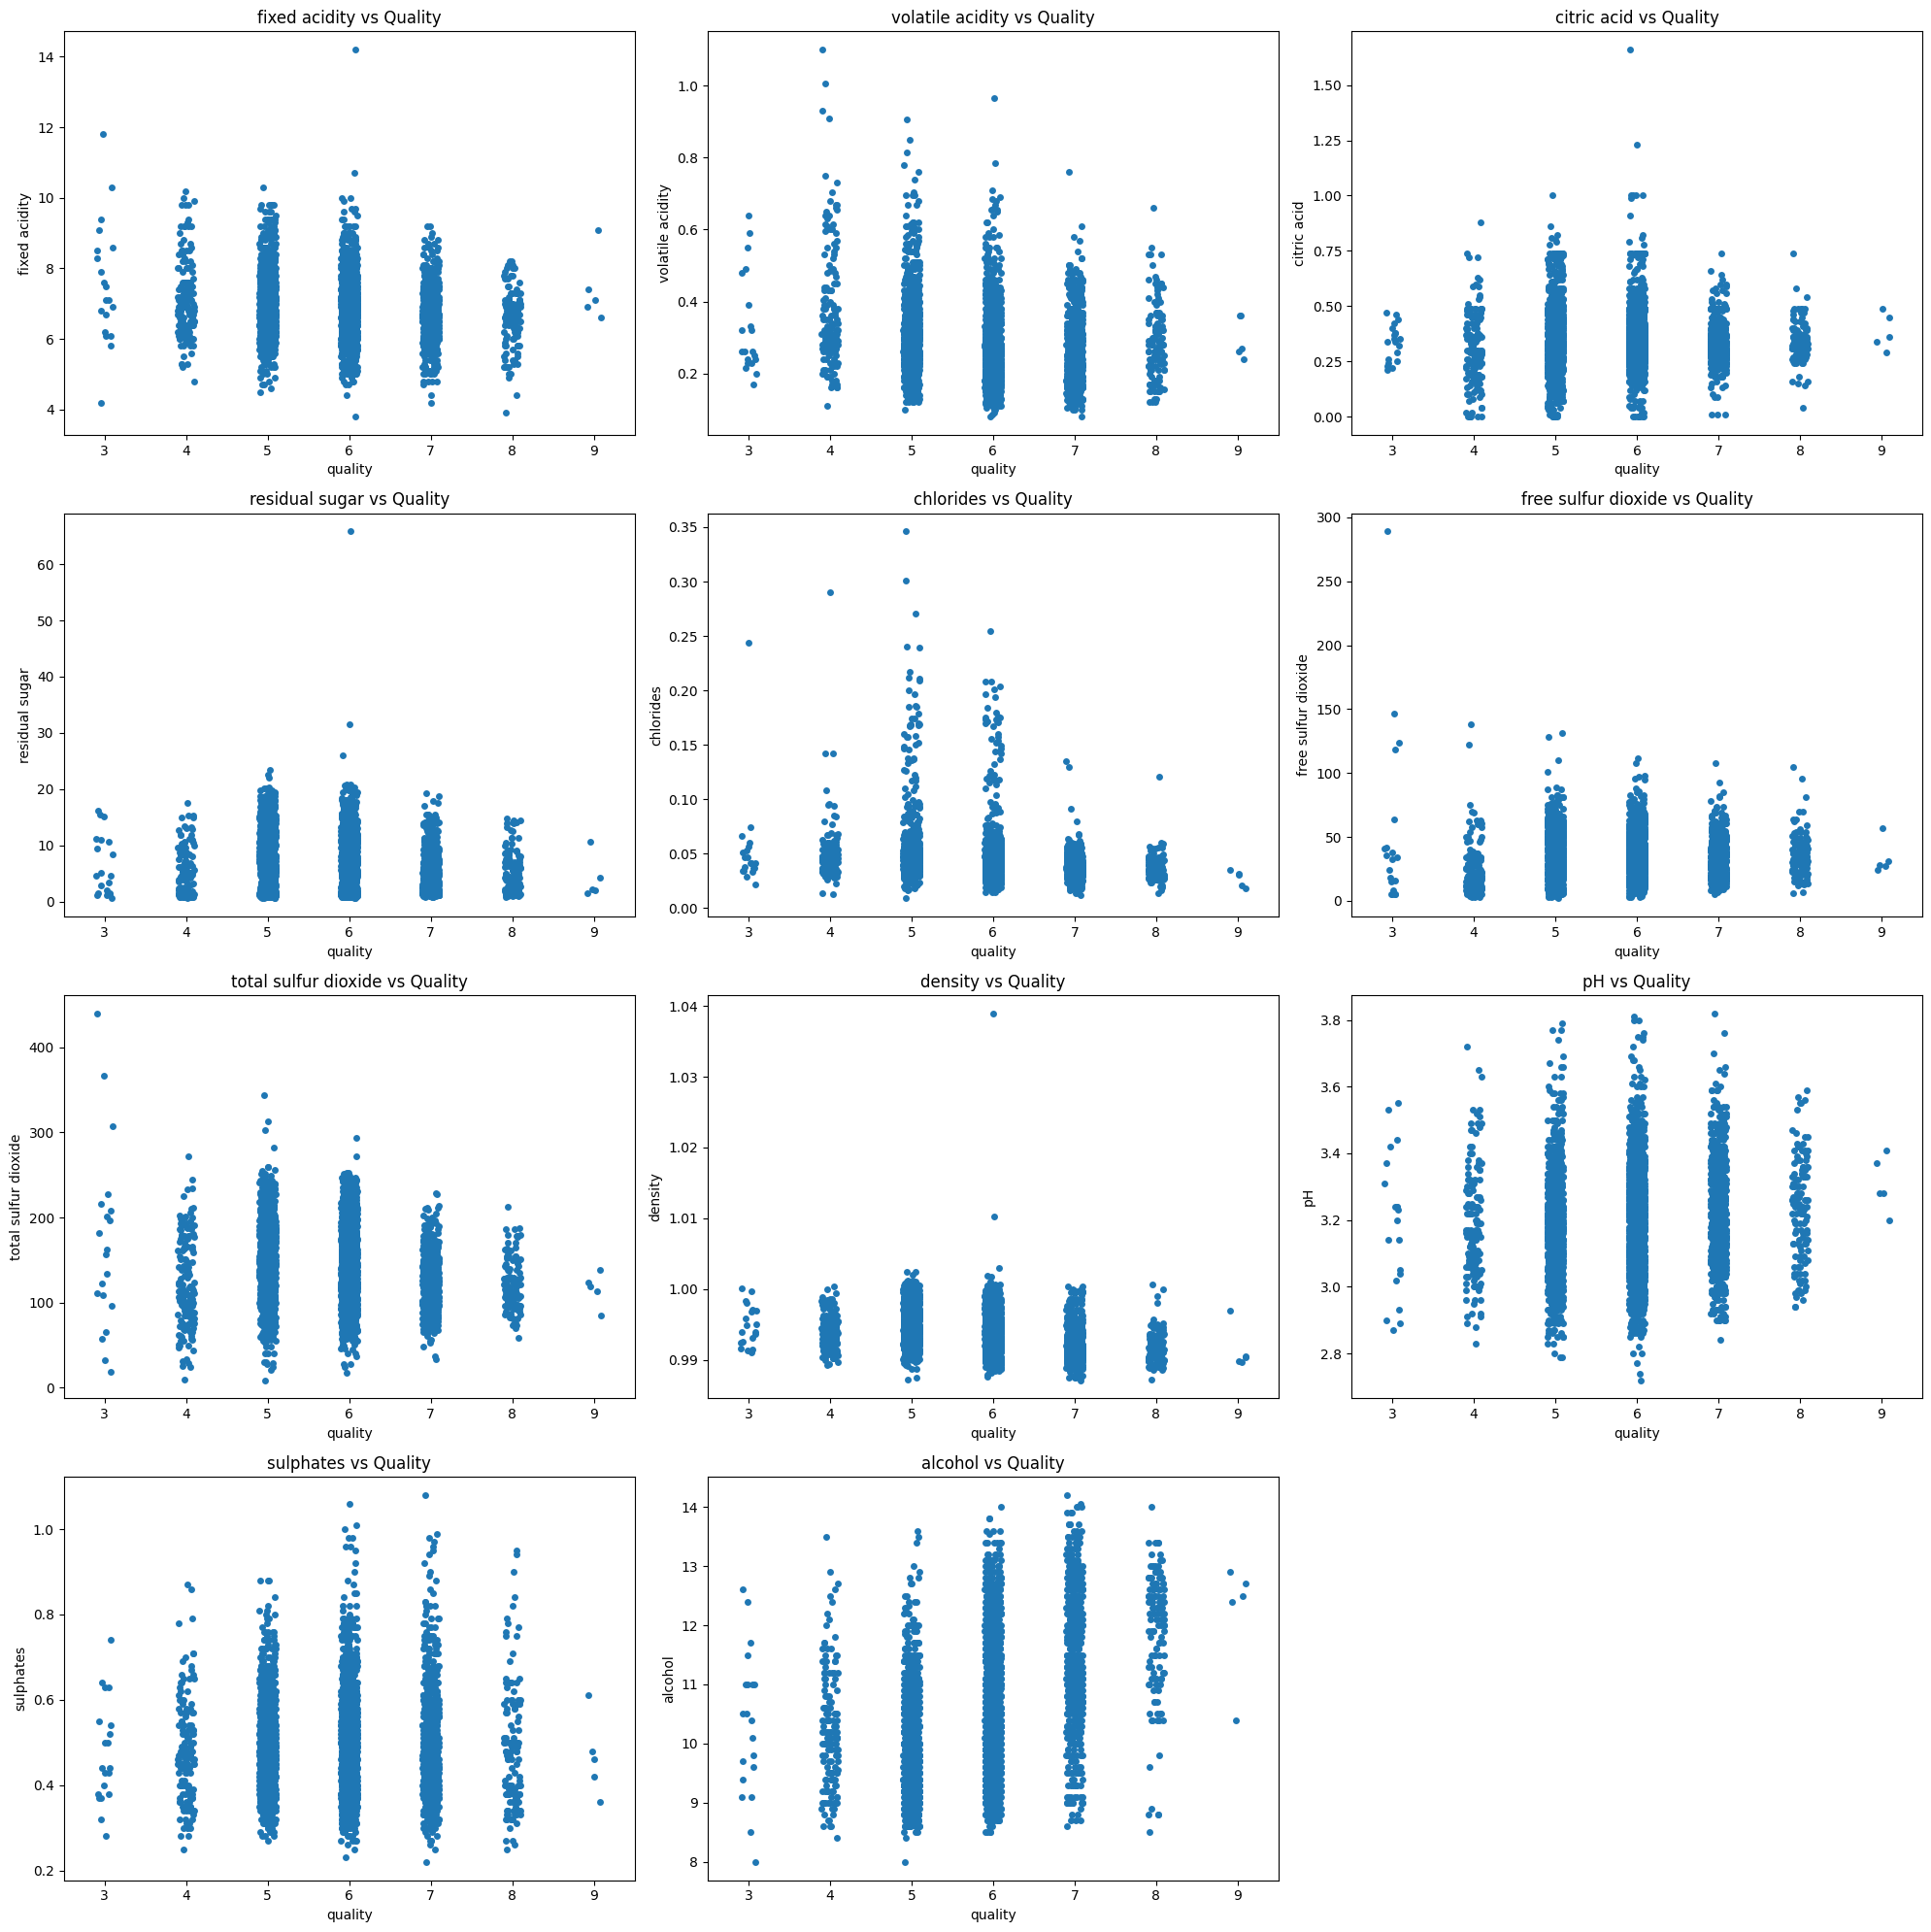

In [17]:
plt.figure(figsize=(15, 15))
sns.heatmap(wine_df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(10, 10))
sns.histplot(wine_df["quality"], bins=10)
plt.title("Quality Histogram")
plt.show()

plt.figure(figsize=(20, 20))
for i, column in enumerate(wine_df.columns):
    if column != "quality":
        plt.subplot(4, 3, i + 1)
        sns.stripplot(x="quality", y=column, data=wine_df, jitter=True)
        plt.title(f"{column} vs Quality")
plt.tight_layout()
plt.show()

#drop density and residual sugar due to correlation and non-normality
wine_df.drop(["density", "residual sugar"], axis=1, inplace=True)

In [18]:
features = wine_df.drop("quality", axis=1)
target = wine_df["quality"]

# Determine feature correlation with quality
alpha = 0.05
remove_cols = []
for column in features.columns:
    _, pval = pearsonr(features[column], target)
    print(f"{column} vs quality pval: {pval}")
    if pval > alpha:
        remove_cols.append(column)

print(f"Removing {len(remove_cols)} uncorrelated columns")
if len(remove_cols) > 0:
    print(f"Removing {remove_cols}")
    features.drop(remove_cols, axis=1, inplace=True)

# NOTE: Convert target to binary representing high quality wines
wine_df["highquality"] = wine_df["quality"].apply(lambda x: 1 if x >= 7 else 0)

# NOTE: No need to scale since we are using tree-based models

fixed acidity vs quality pval: 3.4788252315722896e-15
volatile acidity vs quality pval: 9.570472304980674e-34
citric acid vs quality pval: 0.6566933911784069
chlorides vs quality pval: 1.0170578797809447e-43
free sulfur dioxide vs quality pval: 0.5085713225106695
total sulfur dioxide vs quality pval: 2.7389983717235244e-31
pH vs quality pval: 5.240854950385928e-15
sulphates vs quality pval: 0.0008094044619297985
alcohol vs quality pval: 1.428531029114038e-209
Removing 2 uncorrelated columns
Removing ['citric acid', 'free sulfur dioxide']


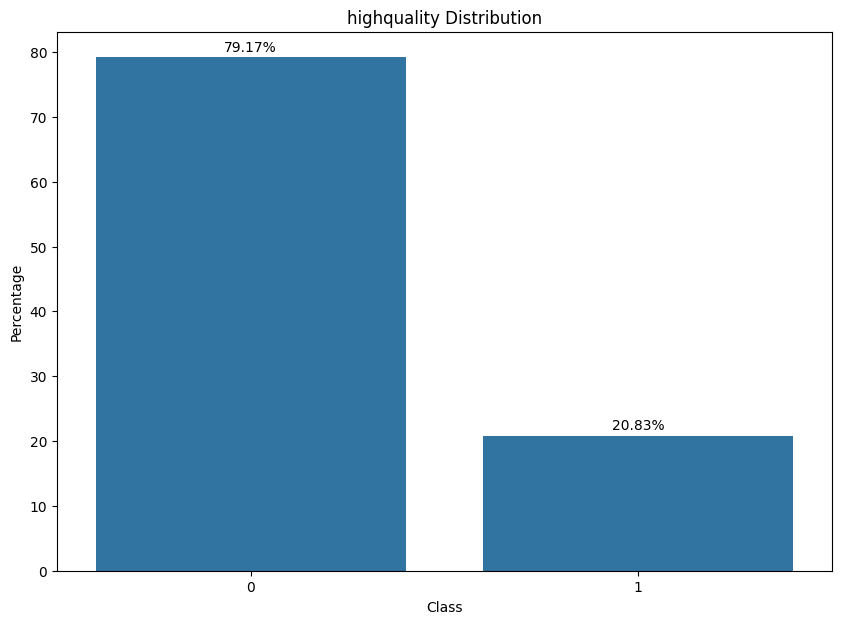

In [19]:
X = wine_df.drop(["quality", "highquality"], axis=1)
y = wine_df["highquality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

class_counts_test = y.value_counts(normalize=True) * 100
plt.figure(figsize=(10, 7))
sns.barplot(x=class_counts_test.index, y=class_counts_test.values)
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.title("highquality Distribution")
for i, value in enumerate(class_counts_test.values):
    plt.text(i, value + 1, f"{value:.2f}%", ha="center")
plt.show()


In [20]:
def visualize_decision_tree(clf, data):
    dot_data = tree.export_graphviz(
        clf.best_estimator_,
        out_file=None,
        feature_names=data.columns,
        class_names=["0", "1"],
        filled=True,
        rounded=True,
        special_characters=True,
    )
    graph = graphviz.Source(dot_data)
    display(graph)


def visualize_random_forest(clf, data):
    features_dict = {}
    for col, val in sorted(
        zip(data.columns, clf.best_estimator_.feature_importances_),
        key=lambda x: x[1],
        reverse=True,
    ):
        features_dict[col] = val

    features_df = pd.DataFrame(
        {"Feature": features_dict.keys(), "Importance": features_dict.values()}
    )
    values = features_df.Importance
    idx = features_df.Feature
    plt.figure(figsize=(10, 8))
    sns.barplot(y=idx, x=values, color="blue").set(
        title="Important features by Random Forest"
    )
    plt.show()


def visualize_adaboost(clf, data):
    features_dict = {}
    for col, val in sorted(
        zip(data.columns, clf.best_estimator_.feature_importances_),
        key=lambda x: x[1],
        reverse=True,
    ):
        features_dict[col] = val

    features_df = pd.DataFrame(
        {"Feature": features_dict.keys(), "Importance": features_dict.values()}
    )
    values = features_df.Importance
    idx = features_df.Feature
    plt.figure(figsize=(10, 8))
    sns.barplot(y=idx, x=values, color="blue").set(
        title="Important features by AdaBoost"
    )
    plt.show()


def visualize_xgboost(clf, data):
    plot_importance(clf.best_estimator_)
    plt.title("Important features by XGBoost")
    plt.show()

In [21]:
CLASSIFIERS = [
    (
        DecisionTreeClassifier(),
        {
            "max_depth": [3, 5, 7],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
        visualize_decision_tree,
    ),
    (
        RandomForestClassifier(),
        {
            "n_estimators": [100, 200],
            "max_depth": [5, 7],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
        },
        visualize_random_forest,
    ),
    (
        AdaBoostClassifier(algorithm="SAMME"),
        {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.5, 1],
        },
        visualize_adaboost,
    ),
    (
        XGBClassifier(),
        {
            "n_estimators": [50, 100],
            "learning_rate": [0.1, 0.5],
            "max_depth": [3, 5, 7],
        },
        visualize_xgboost,
    ),
]


Training DecisionTreeClassifier
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Training Accuracy for DecisionTreeClassifier: 0.8030344710731032
Testing Accuracy: 0.798234552332913
Classification Report: 
 DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       630
           1       0.52      0.29      0.38       163

    accuracy                           0.80       793
   macro avg       0.68      0.61      0.63       793
weighted avg       0.77      0.80      0.78       793



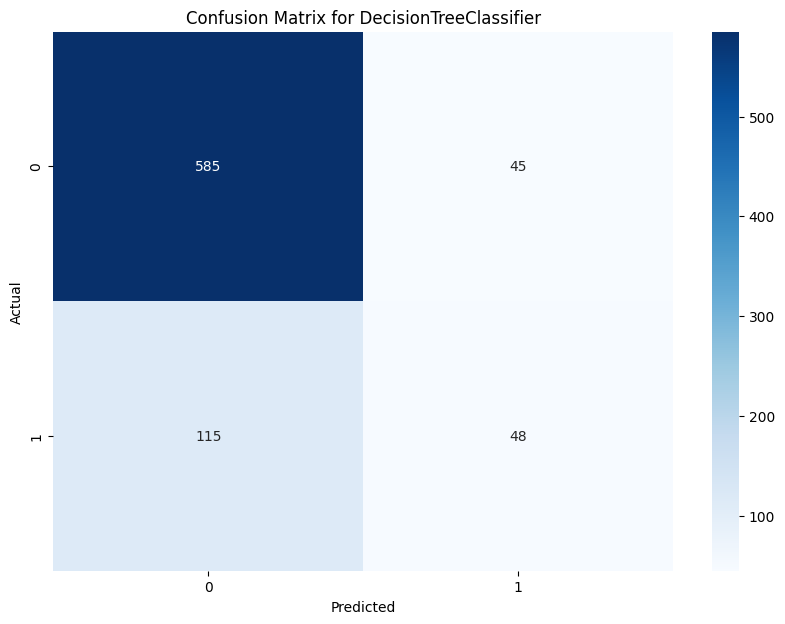

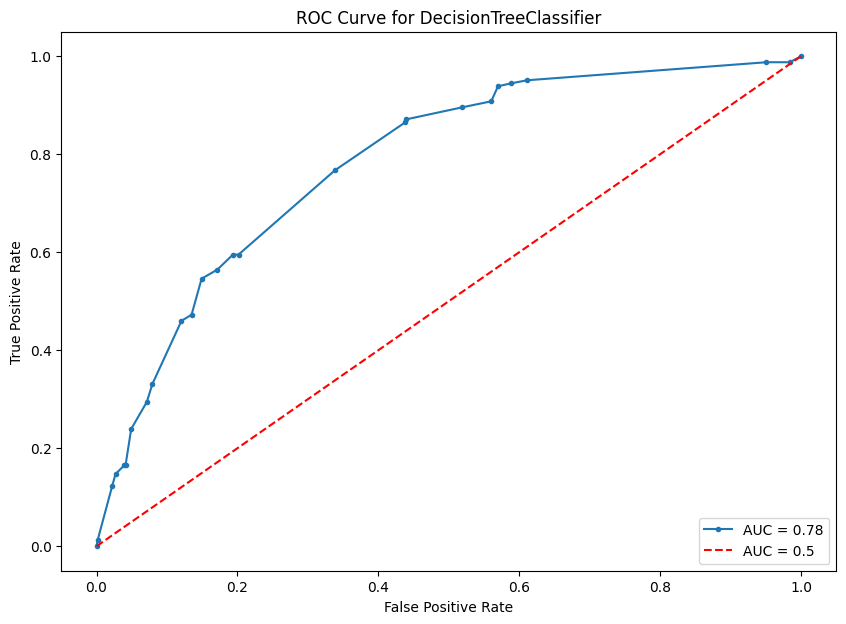

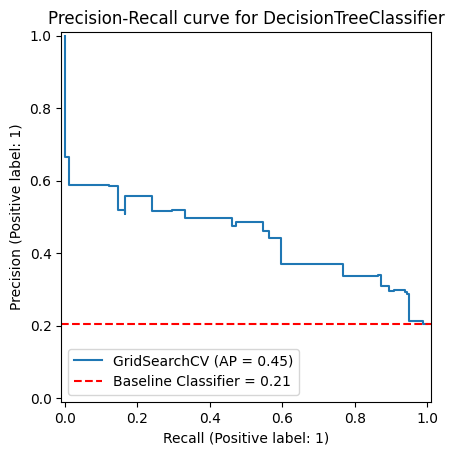

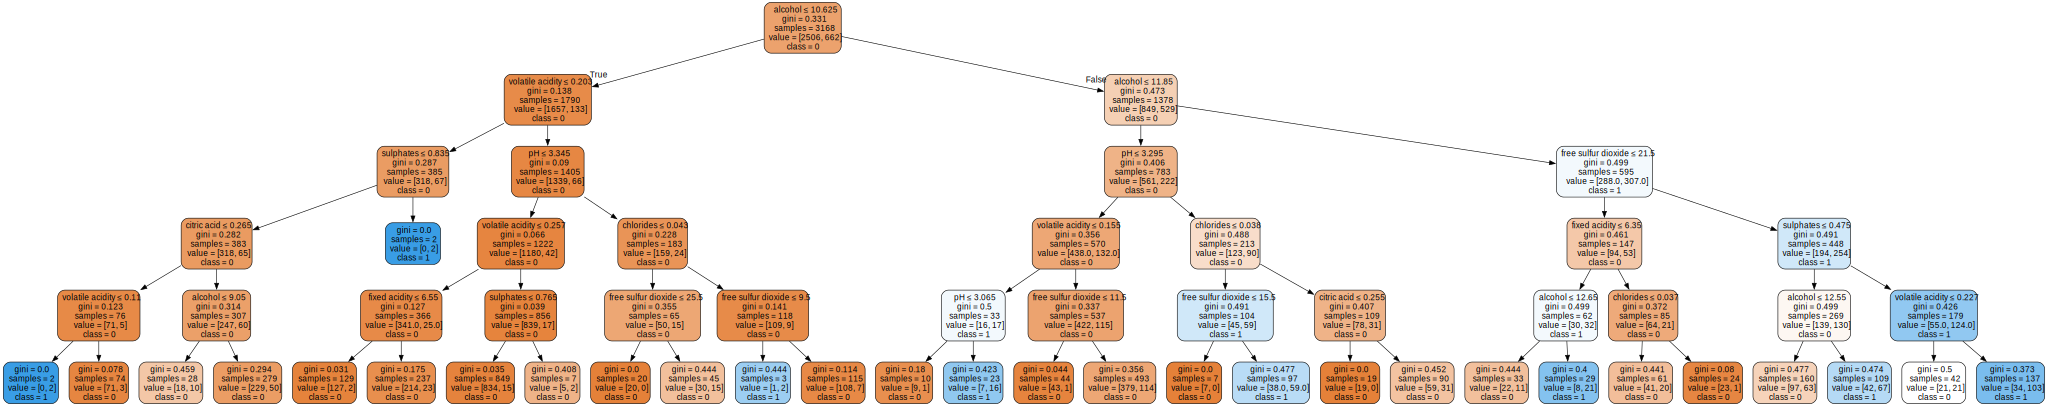


Training RandomForestClassifier
Best parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Training Accuracy for RandomForestClassifier: 0.8213389746886539
Testing Accuracy: 0.819672131147541
Classification Report: 
 RandomForestClassifier
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       630
           1       0.62      0.31      0.42       163

    accuracy                           0.82       793
   macro avg       0.73      0.63      0.65       793
weighted avg       0.80      0.82      0.80       793



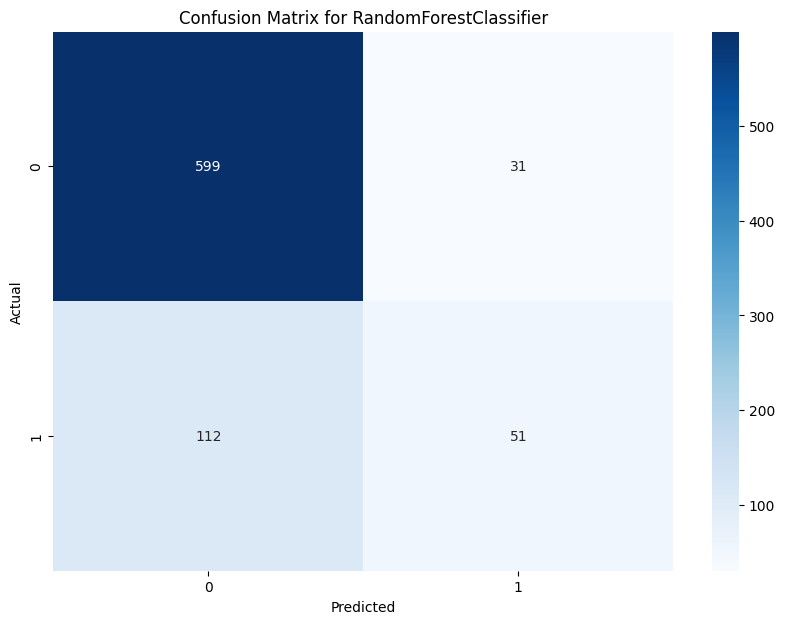

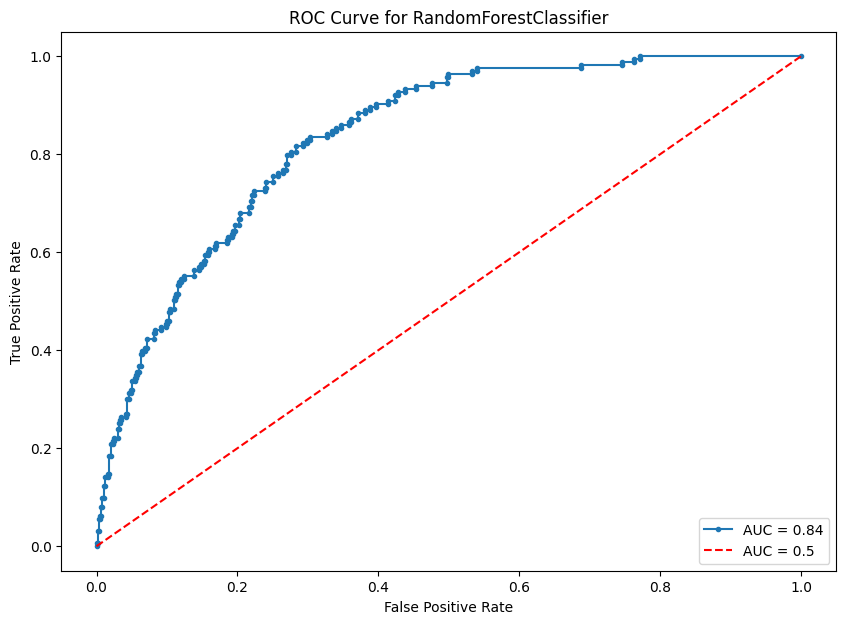

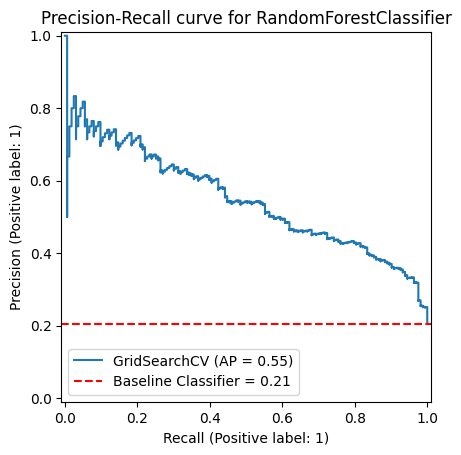

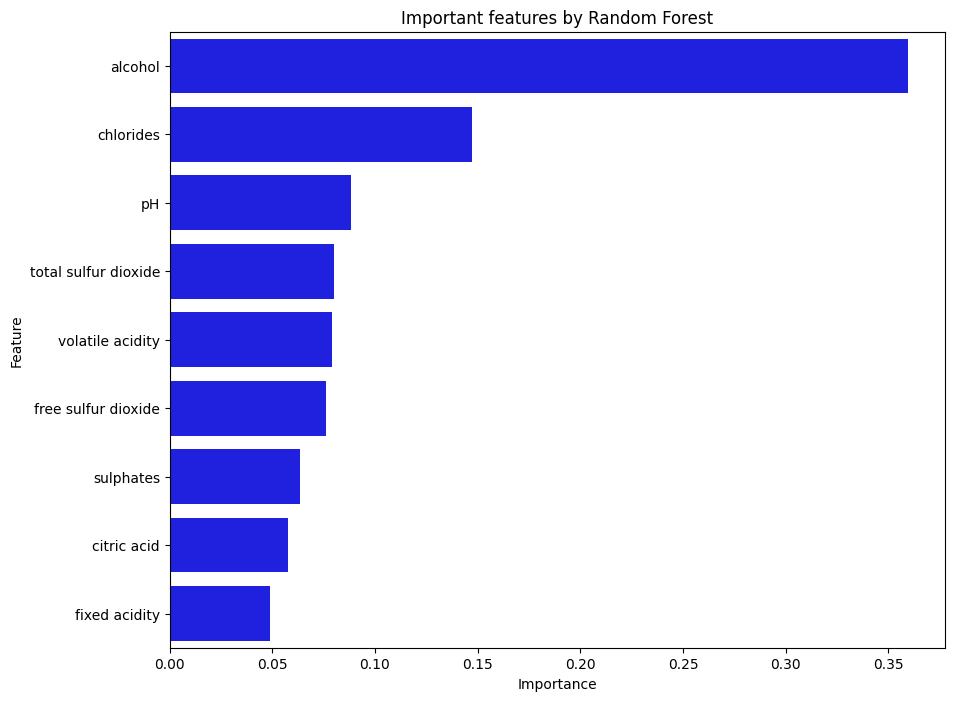


Training AdaBoostClassifier
Best parameters: {'learning_rate': 0.5, 'n_estimators': 200}
Best Training Accuracy for AdaBoostClassifier: 0.8121807426455565
Testing Accuracy: 0.8184110970996217
Classification Report: 
 AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       630
           1       0.65      0.26      0.37       163

    accuracy                           0.82       793
   macro avg       0.74      0.61      0.63       793
weighted avg       0.80      0.82      0.79       793



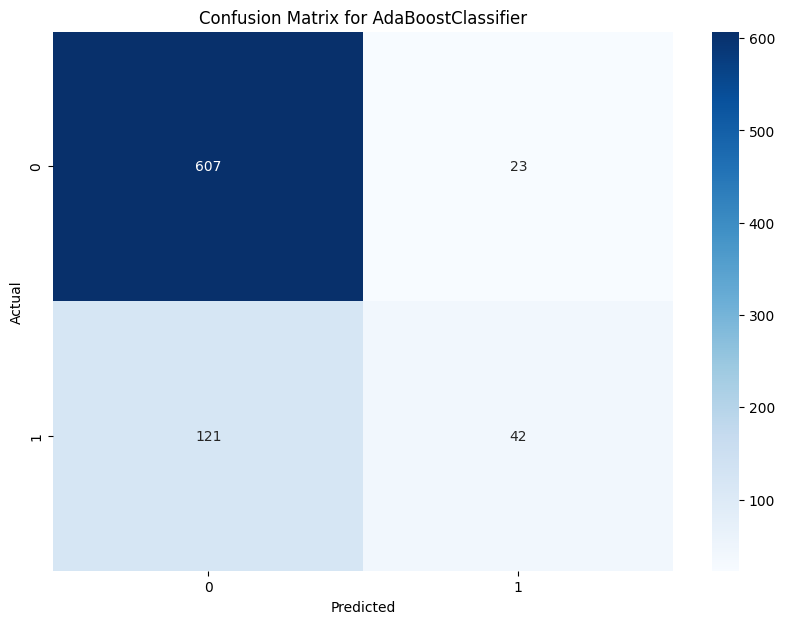

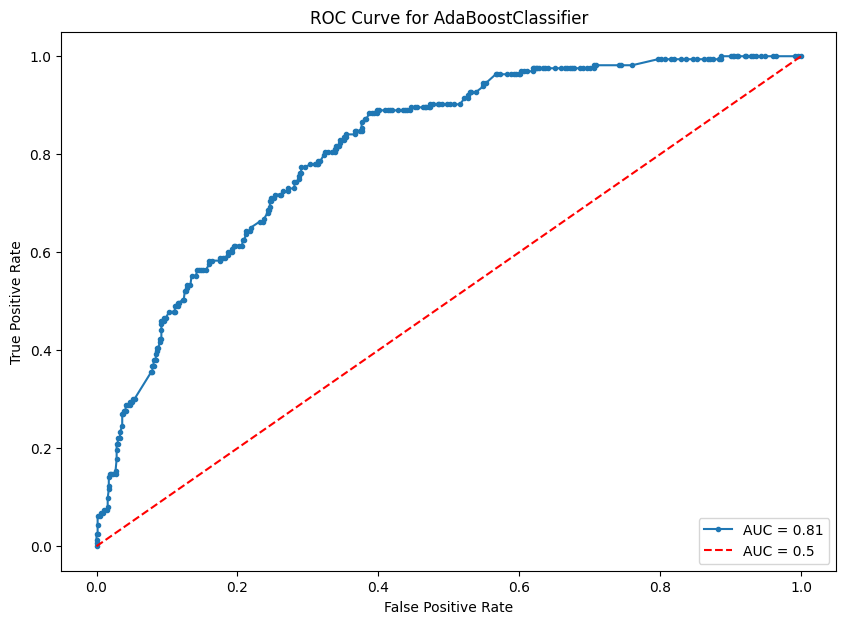

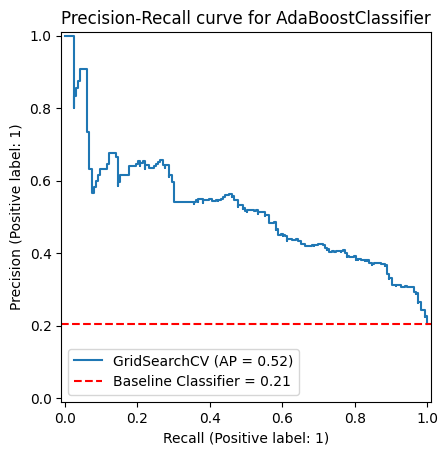

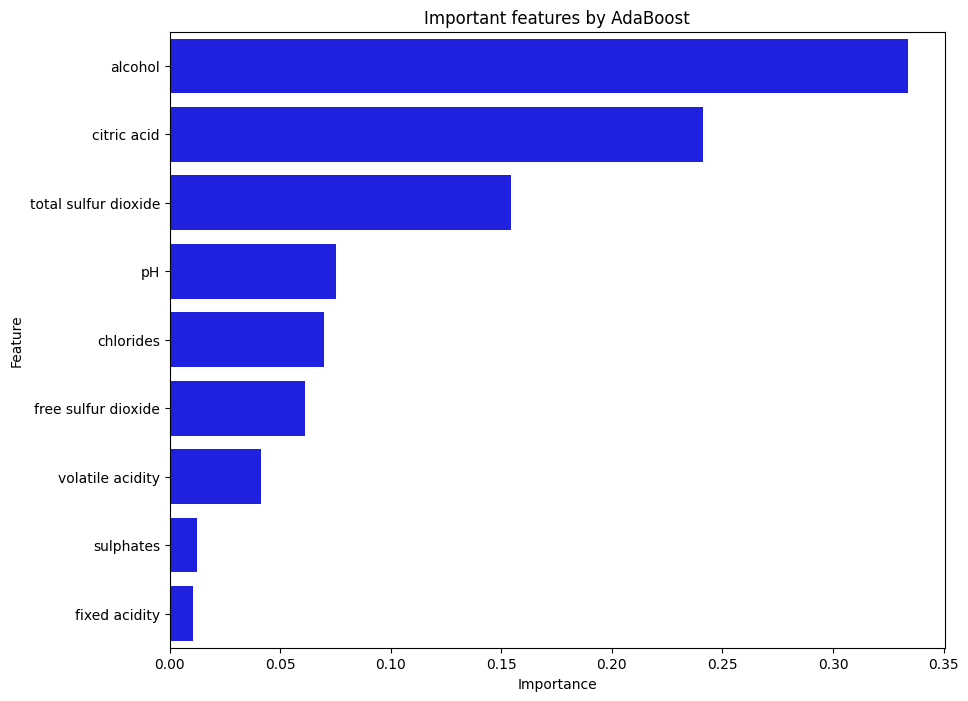


Training XGBClassifier
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
Best Training Accuracy for XGBClassifier: 0.8200776433886008
Testing Accuracy: 0.819672131147541
Classification Report: 
 XGBClassifier
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       630
           1       0.60      0.37      0.46       163

    accuracy                           0.82       793
   macro avg       0.73      0.65      0.68       793
weighted avg       0.80      0.82      0.80       793



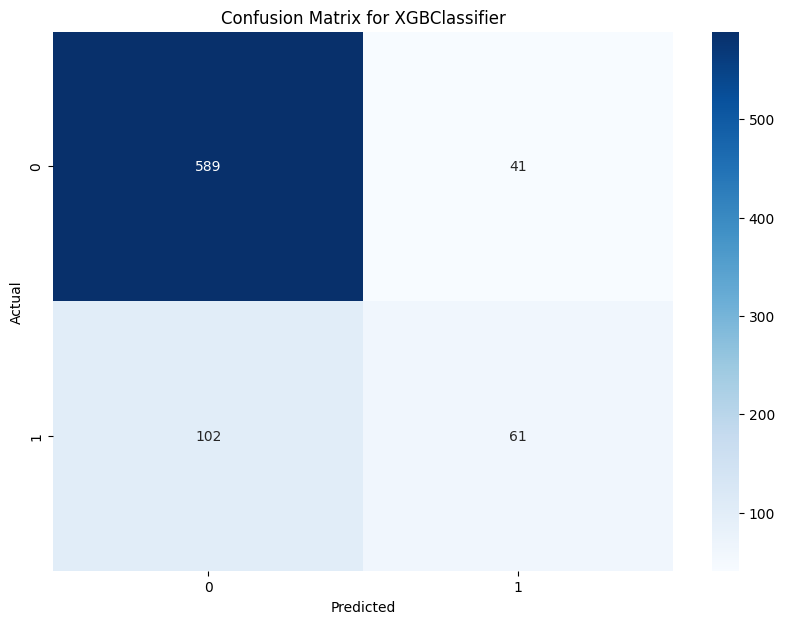

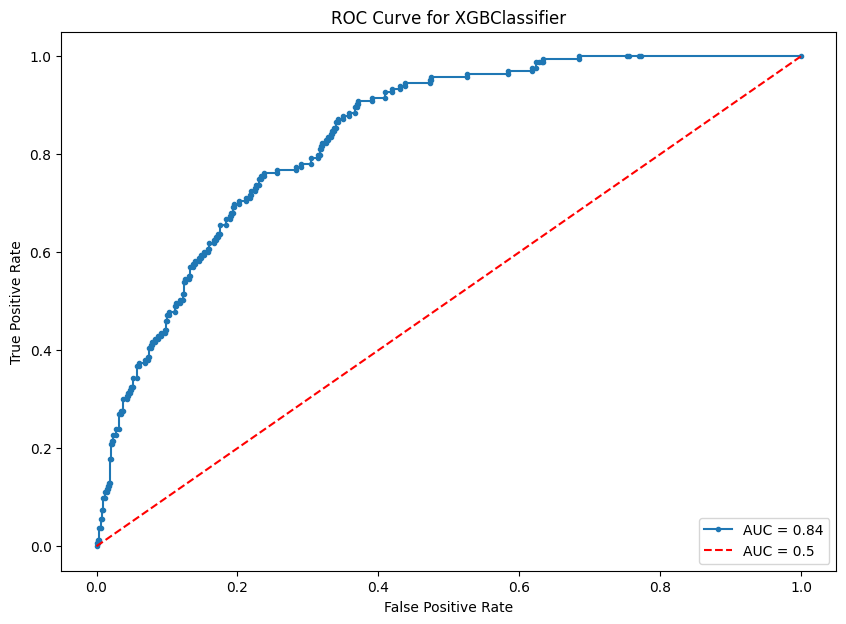

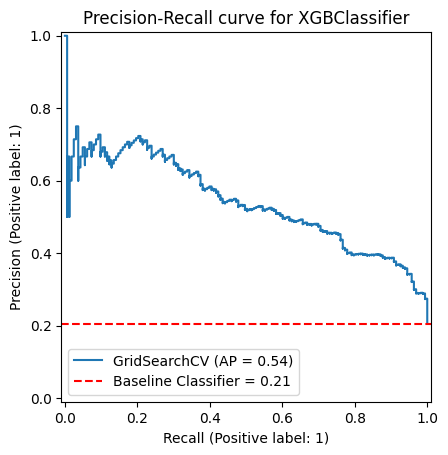

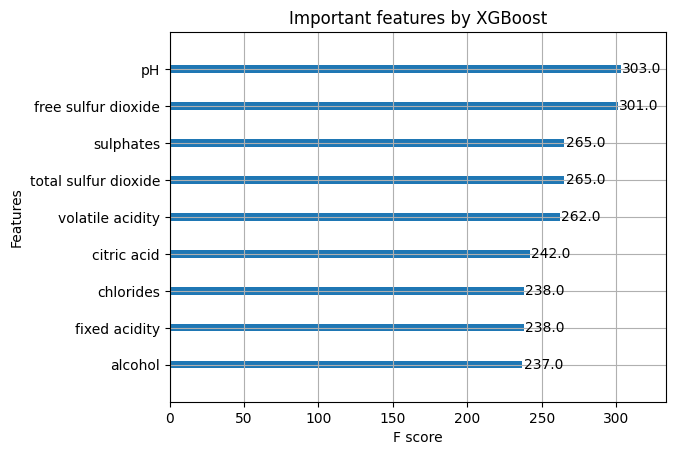

In [22]:
for model, params, viz_fn in CLASSIFIERS:
    print(f"\nTraining {model.__class__.__name__}")
    clf = GridSearchCV(model, params, cv=5, n_jobs=-1, scoring="accuracy")
    clf.fit(X_train, y_train)

    # TODO: All the evaluation code
    print(f"Best parameters: {clf.best_params_}")
    print(f"Best Training Accuracy for {model.__class__.__name__}: {clf.best_score_}")

    ### predict and evaluate on test set
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Testing Accuracy: {accuracy}")

    ### Classifcation report
    print(
        f"Classification Report: \n {model.__class__.__name__}\n{classification_report(y_test, y_pred)}"
    )

    ### confusion matrix and show plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

    # calculate roc curve and auc
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    # plot roc curve for the model
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, marker=".", label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="r", label="AUC = 0.5")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model.__class__.__name__}")
    plt.legend(loc="lower right")
    plt.show()

    # plot precision-recall curve for the model
    precision_recall_display = PrecisionRecallDisplay.from_estimator(
        clf, X_test, y_test
    )
    class_counts = y_test.value_counts(normalize=True)
    plt.axhline(
        y=class_counts[1],
        color="r",
        linestyle="--",
        label=f"Baseline Classifier = {class_counts[1]:.2f}",
    )
    plt.legend(loc="lower left")
    plt.title(f"Precision-Recall curve for {model.__class__.__name__}")
    plt.show()

    viz_fn(clf, X_train)



Training DecisionTreeClassifier
Testing Accuracy: 0.7377049180327869
Classification Report: 
 DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       630
           1       0.37      0.41      0.39       163

    accuracy                           0.74       793
   macro avg       0.61      0.62      0.61       793
weighted avg       0.75      0.74      0.74       793



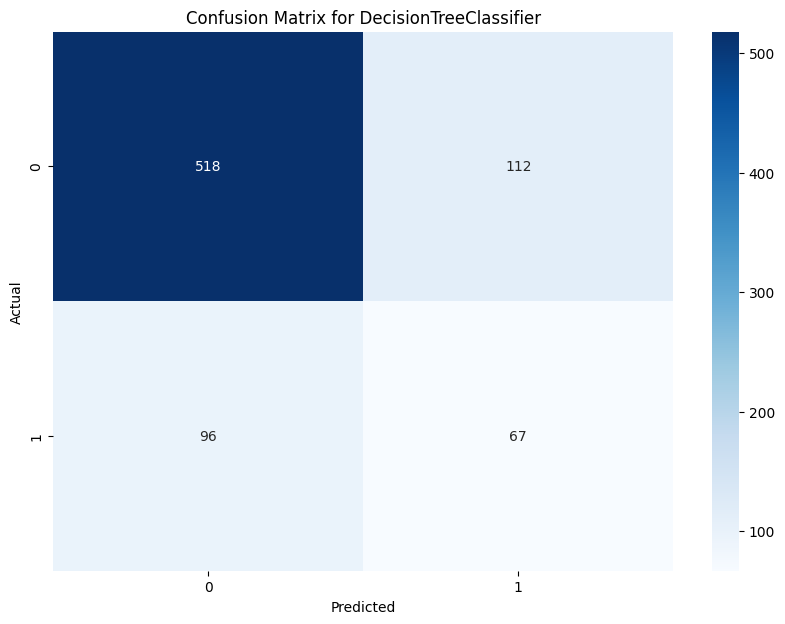

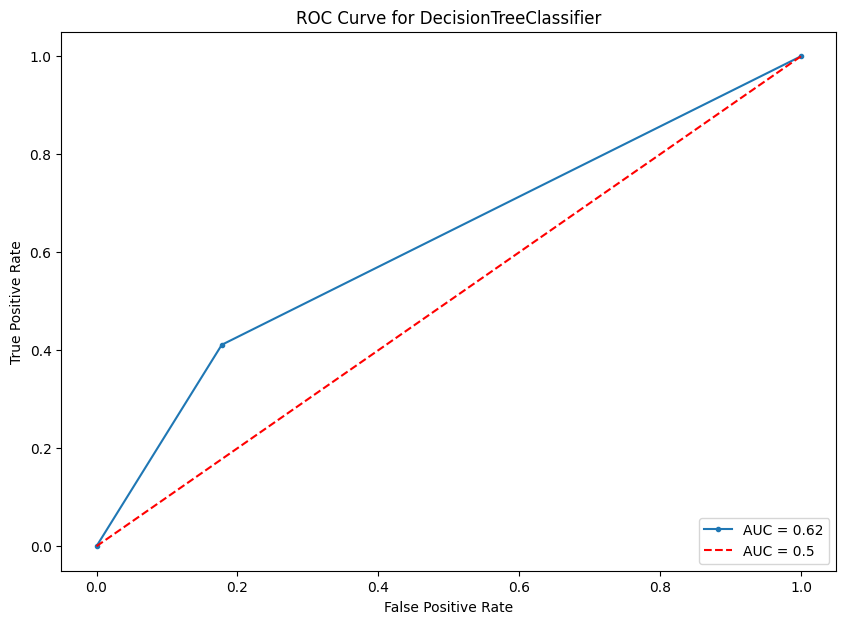

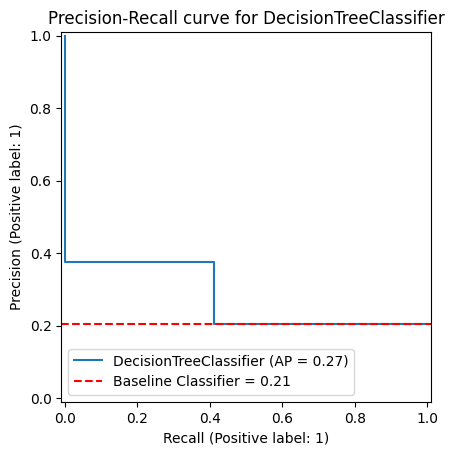


Training RandomForestClassifier
Testing Accuracy: 0.8310214375788146
Classification Report: 
 RandomForestClassifier
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       630
           1       0.65      0.38      0.48       163

    accuracy                           0.83       793
   macro avg       0.75      0.66      0.69       793
weighted avg       0.81      0.83      0.81       793



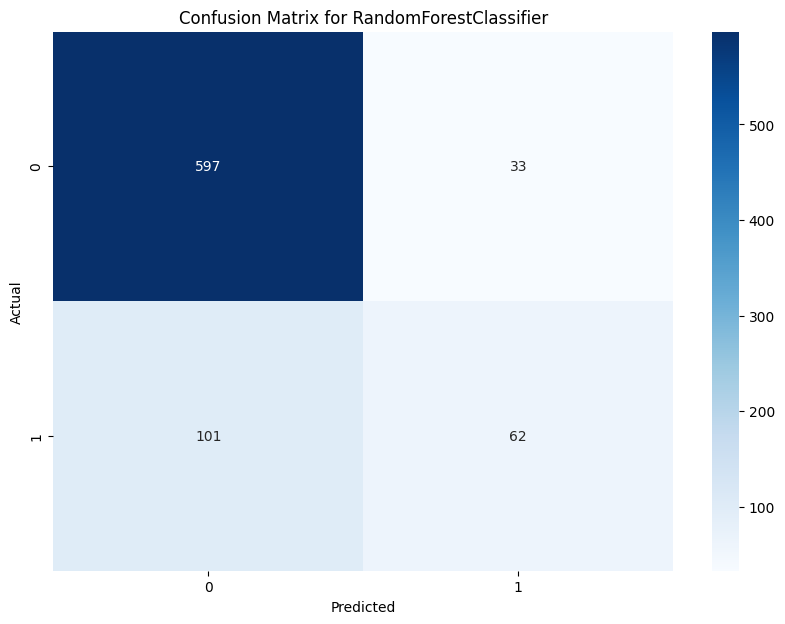

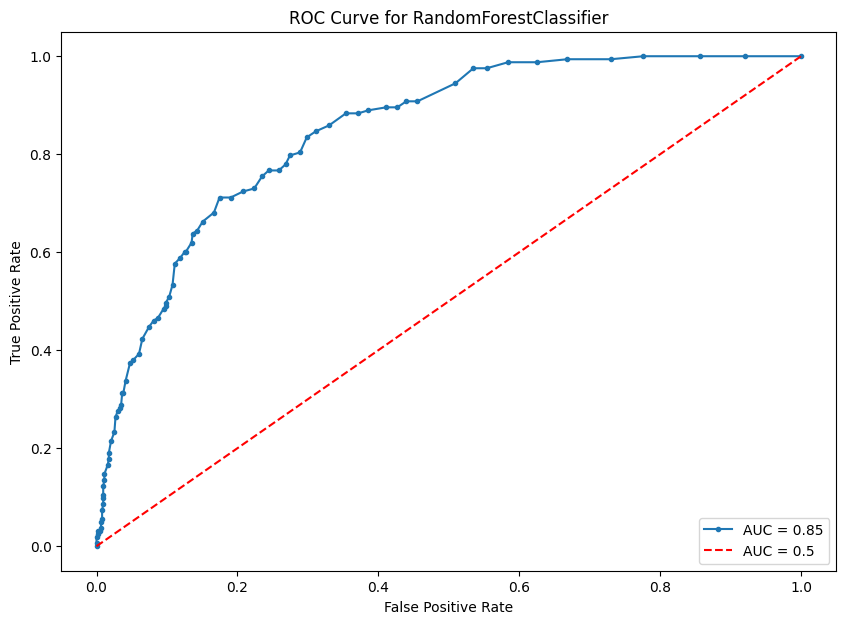

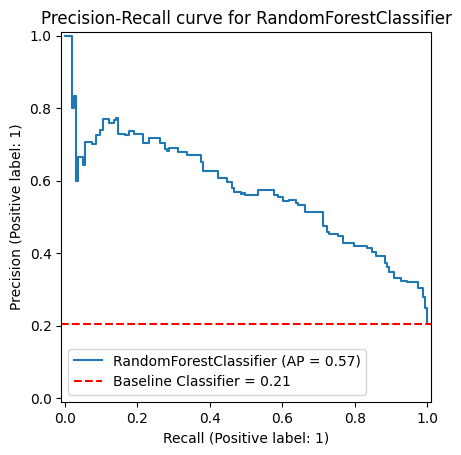


Training AdaBoostClassifier
Testing Accuracy: 0.8095838587641866
Classification Report: 
 AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       630
           1       0.57      0.29      0.39       163

    accuracy                           0.81       793
   macro avg       0.70      0.62      0.64       793
weighted avg       0.78      0.81      0.78       793



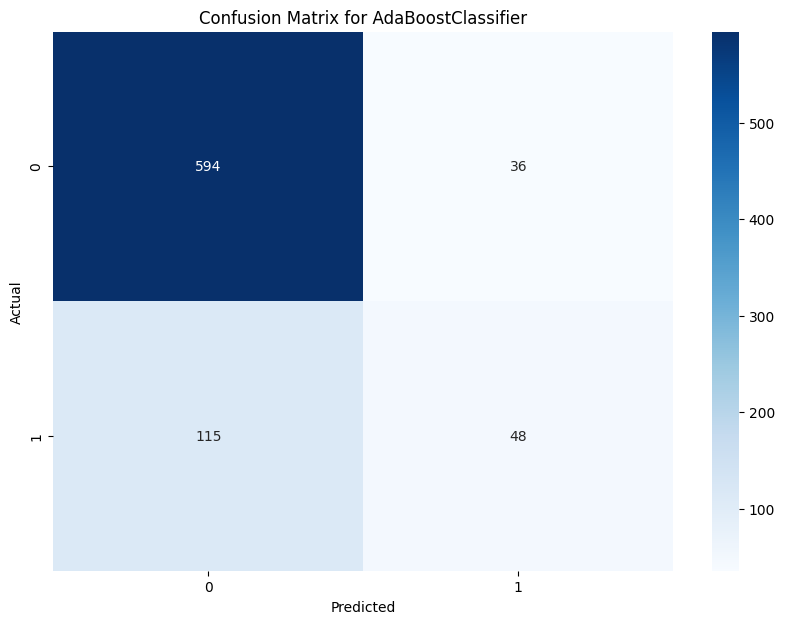

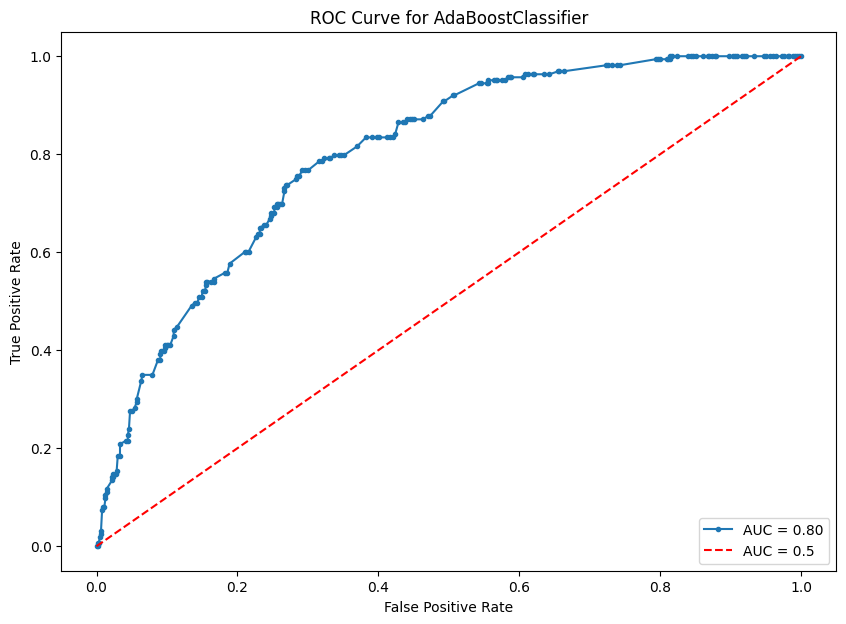

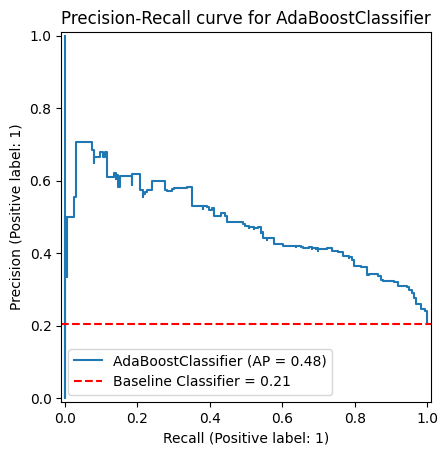


Training XGBClassifier
Testing Accuracy: 0.8234552332912989
Classification Report: 
 XGBClassifier
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       630
           1       0.59      0.45      0.51       163

    accuracy                           0.82       793
   macro avg       0.73      0.69      0.70       793
weighted avg       0.81      0.82      0.81       793



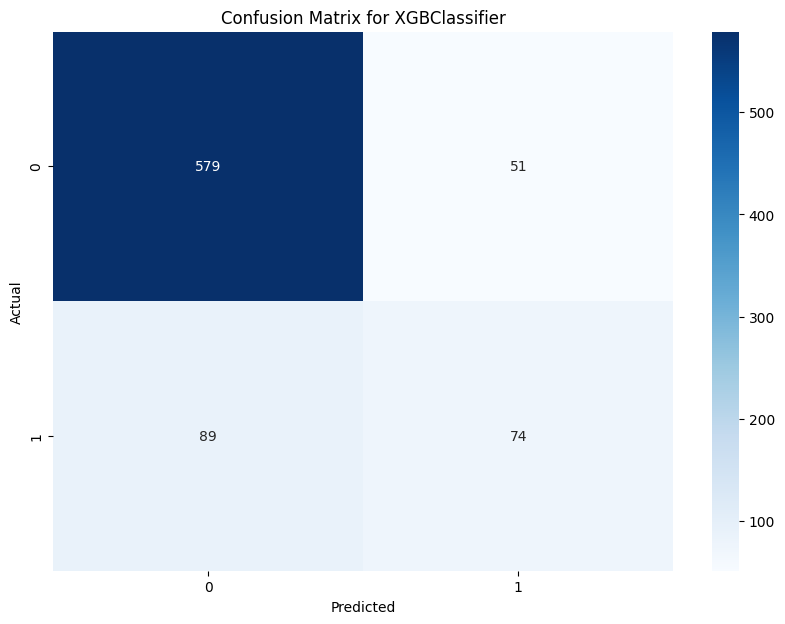

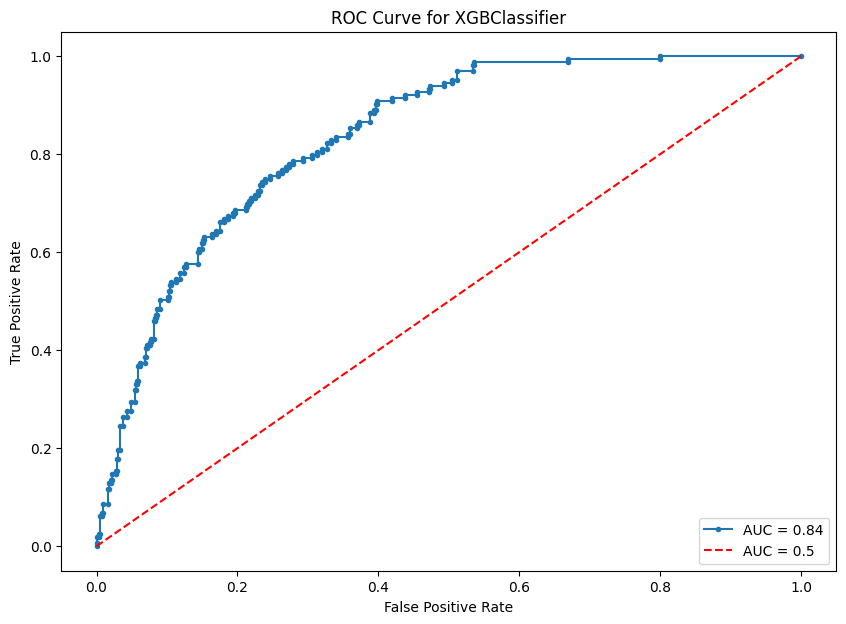

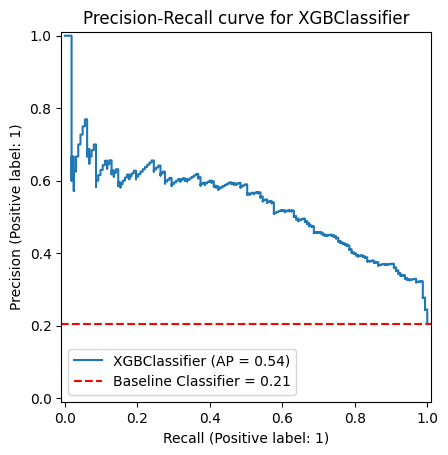

In [23]:
for model, _, _ in CLASSIFIERS:
    print(f"\nTraining {model.__class__.__name__}")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Testing Accuracy: {accuracy}")

    ### Classifcation report
    print(
        f"Classification Report: \n {model.__class__.__name__}\n{classification_report(y_test, y_pred)}"
    )

    ### confusion matrix and show plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

    # calculate roc curve and auc
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    # plot roc curve for the model
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, marker=".", label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="r", label="AUC = 0.5")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model.__class__.__name__}")
    plt.legend(loc="lower right")
    plt.show()

    # plot precision-recall curve for the model
    precision_recall_display = PrecisionRecallDisplay.from_estimator(
        model, X_test, y_test
    )
    class_counts = y_test.value_counts(normalize=True)
    plt.axhline(
        y=class_counts[1],
        color="r",
        linestyle="--",
        label=f"Baseline Classifier = {class_counts[1]:.2f}",
    )
    plt.legend(loc="lower left")
    plt.title(f"Precision-Recall curve for {model.__class__.__name__}")
    plt.show()